# Crawling PTA & Berita

In [2]:
!pip install builtwith
!pip install nltk
!pip install Sastrawi
!pip install pyspellchecker

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## 1. Crawling PTA

In [ ]:
import builtwith

# Analisis teknologi yang digunakan
res = builtwith.parse('https://pta.trunojoyo.ac.id')
print(res)

{'web-servers': ['Nginx'], 'javascript-frameworks': ['jQuery', 'jQuery UI']}


## Crawling PTA

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import sys

def get_text_or_na(soup, selectors):
    """Mencoba beberapa selektor untuk menemukan teks, mengembalikan 'N/A' jika tidak ditemukan."""
    for selector in selectors:
        element = soup.select_one(selector)
        if element:
            text = element.get_text(strip=True)
            if text and text.strip():
                return text.strip()
    return 'N/A'

def get_data_from_span(soup, text_contains):
    """Mencari span yang berisi teks tertentu dan mengekstrak nama setelah titik dua."""
    span = soup.select_one(f'span:-soup-contains("{text_contains}")')
    if span:
        text = span.get_text(strip=True)
        if ':' in text:
            return text.split(':', 1)[1].strip()
    return 'N/A'

def get_abstract_robust(soup, keywords):
    """
    Mencari tag heading (b) yang teksnya mengandung salah satu dari kata kunci
    dan mengekstrak paragraf berikutnya.
    """
    for tag_b in soup.find_all('b'):
        tag_text = tag_b.get_text(strip=True)
        if any(keyword.lower() in tag_text.lower() for keyword in keywords):
            parent_div = tag_b.find_parent('div')
            if parent_div:
                next_div_sibling = parent_div.find_next_sibling('div')
                if next_div_sibling:
                    p_tag = next_div_sibling.find('p', align="justify")
                    if p_tag:
                        abstract_text = p_tag.get_text(strip=True)
                        if abstract_text:
                            return abstract_text
    return 'N/A'

def get_total_pages(soup):
    """
    Mengekstrak total jumlah halaman dari navigasi paginasi.
    """
    try:
        pagination = soup.select_one('ol.pagination')
        if pagination:
            last_page_li = pagination.select('li')[-1]
            last_page_link = last_page_li.select_one('a')
            if last_page_link and 'href' in last_page_link.attrs:
                url_path = last_page_link['href']
                return int(url_path.split('/')[-1])
    except (IndexError, ValueError, KeyError):
        pass
    return 1

def scrape_teknik_all_data():
    """
    Scrapes all data from all study programs within the Faculty of Engineering.
    """
    # Hardcoded list of Engineering study programs and their URLs based on inspection
    prodi_data = [
        {'name': 'Teknik Industri', 'url': 'https://pta.trunojoyo.ac.id/c_search/byprod/9'},
        {'name': 'Teknik Informatika', 'url': 'https://pta.trunojoyo.ac.id/c_search/byprod/10'},
        {'name': 'Manajemen Informatika', 'url': 'https://pta.trunojoyo.ac.id/c_search/byprod/11'},
        {'name': 'Teknik Multimedia Dan Jaringan', 'url': 'https://pta.trunojoyo.ac.id/c_search/byprod/19'},
        {'name': 'Mekatronika', 'url': 'https://pta.trunojoyo.ac.id/c_search/byprod/20'},
        {'name': 'Teknik Elektro', 'url': 'https://pta.trunojoyo.ac.id/c_search/byprod/23'},
        {'name': 'Sistem Informasi', 'url': 'https://pta.trunojoyo.ac.id/c_search/byprod/31'},
        {'name': 'Teknik Mesin', 'url': 'https://pta.trunojoyo.ac.id/c_search/byprod/32'},
        {'name': 'Teknik Mekatronika', 'url': 'https://pta.trunojoyo.ac.id/c_search/byprod/33'}
    ]

    all_scraped_data = {
        "penulis": [], "judul": [], "pembimbing_pertama": [], "pembimbing_kedua": [],
        "abstrak_indonesia": [], "abstrak_inggris": [], "prodi": []
    }

    total_data_count = 0

    print("--- MULAI PROSES SCRAPING FAKULTAS TEKNIK ---")

    for prodi in prodi_data:
        print(f"\nScraping data for program: {prodi['name']}")
        print("-" * 50)

        first_page_url = prodi['url']
        try:
            r = requests.get(first_page_url)
            r.raise_for_status()
            soup = BeautifulSoup(r.content, "html.parser")
            total_pages = get_total_pages(soup)
            print(f"Found {total_pages} pages for {prodi['name']}")
        except requests.exceptions.RequestException as e:
            print(f"Error fetching first page for {prodi['name']}: {e}", file=sys.stderr)
            total_pages = 1

        for i in range(1, total_pages + 1):
            url = f"{prodi['url']}/{i}"

            try:
                r = requests.get(url)
                r.raise_for_status()
                soup = BeautifulSoup(r.content, "html.parser")
                jurnals = soup.select('li[data-cat="#luxury"]')

                if not jurnals:
                    print(f"No more journals found on page {i}. Stopping for this program.")
                    break

                for jurnal in jurnals:
                    jurnal_url = jurnal.select_one('a.gray.button')['href']

                    try:
                        response = requests.get(jurnal_url)
                        response.raise_for_status()
                        soup1 = BeautifulSoup(response.content, "html.parser")
                        isi = soup1.select_one('div#content_journal')

                        if isi:
                            judul = get_text_or_na(isi, ['a.title', 'b.title', 'h2.title'])
                            penulis = get_data_from_span(isi, "Penulis")
                            pembimbing_pertama = get_data_from_span(isi, "Dosen Pembimbing I")
                            pembimbing_kedua = get_data_from_span(isi, "Dosen Pembimbing II")
                            abstrak_indonesia = get_abstract_robust(isi, ["Abstraksi", "Abstrak"])
                            abstrak_inggris = get_abstract_robust(isi, ["Abstraction", "Abstract", "ABSTRACT"])

                            all_scraped_data["penulis"].append(penulis)
                            all_scraped_data["judul"].append(judul)
                            all_scraped_data["pembimbing_pertama"].append(pembimbing_pertama)
                            all_scraped_data["pembimbing_kedua"].append(pembimbing_kedua)
                            all_scraped_data["abstrak_indonesia"].append(abstrak_indonesia)
                            all_scraped_data["abstrak_inggris"].append(abstrak_inggris)
                            all_scraped_data["prodi"].append(prodi['name'])

                            total_data_count += 1

                            # Print all data for the current entry
                            print(f"\n--- Data #{total_data_count} ---")
                            print(f"Prodi: {prodi['name']}")
                            print(f"Penulis: {penulis}")
                            print(f"Judul: {judul}")
                            print(f"Pembimbing 1: {pembimbing_pertama}")
                            print(f"Pembimbing 2: {pembimbing_kedua}")
                            print(f"Abstrak Indonesia: {abstrak_indonesia}")
                            print(f"Abstrak Inggris: {abstrak_inggris}")

                    except Exception as e:
                        print(f"ERROR: An error occurred while processing URL: {jurnal_url} - {e}", file=sys.stderr)

                time.sleep(1)

            except requests.exceptions.RequestException as e:
                print(f"Error fetching URL {url}: {e}", file=sys.stderr)
                continue

    df = pd.DataFrame(all_scraped_data)
    df.to_csv("pta_teknik_complete.csv", index=False)
    print("\n---")
    print(f"Scraping finished. Total data scraped: {total_data_count}")
    print("Data saved to pta_teknik_complete.csv")
    print("---")
    return df

# Run the full scraping process
scrape_teknik_all_data()

--- MULAI PROSES SCRAPING FAKULTAS TEKNIK ---

Scraping data for program: Teknik Industri
--------------------------------------------------
Found 143 pages for Teknik Industri

--- Data #1 ---
Prodi: Teknik Industri
Penulis: Siliwangi Fitra Rachmawanto S.T.
Judul: OPTIMASI PEMILIHAN PORTOFOLIO SAHAM PERUSAHAAN SEKTOR TAMBANG DENGAN MENGGUNAKAN GOAL PROGRAMMING
Pembimbing 1: Heri Awalul Ilhamsah S.T., M.T.
Pembimbing 2: Retno Indriartiningtias S.T., M.T.
Abstrak Indonesia: Portofolio adalah sekumpulan saham yang dimiliki investor. Dalam setiap saham pada portofolio memiliki resiko yang harus diminimalkan dengan cara diversifikasi yaitu dengan mengalokasikan dana pada berbagai alternatif investasi pada kombinasi saham pada portofolio. Pada skripsi ini, saham yang digunakan berupa saham dari perusahan sektor tambang yang terdapat 4 subsektor didalamnya yaitu subsektor Batubara, subsektor batu-batuan, subsektor logam dan mineral lainnya, dan subsektor minyak dan gas bumi. Dari setiap subs

penulis  \
0     Siliwangi Fitra Rachmawanto S.T.   
1                         AHMAD MAS'UD   
2                    Yulianto Fauzanta   
3                    M Mundir Muhlisin   
4                             Muhibbin   
...                                ...   
2289                   Raudatul Jannah   
2290                        Ach. Dafid   
2291                         MOH HOLIL   
2292                 Ach Imam Sudianto   
2293                MOH TAUFIK HIDAYAT   

                                                  judul  \
0     OPTIMASI PEMILIHAN PORTOFOLIO SAHAM PERUSAHAAN...   
1     PERANCANGAN TATA LETAK FASILITAS LANTAI PRODUK...   
2     PERUMUSAN STRATEGI BISNIS UD. BUDI JAYA BANGKA...   
3     USULAN PERBAIKAN UTILITAS RESOURCES PADA LANTA...   
4     Peningkatan Kepuasan Masyarakat Terhadap Pelay...   
...                                                 ...   
2289  ROBOT PENDETEKSI LOKASI KEBOCORAN PADA PIPA LI...   
2290  SISTEM KENDALI KADAR Ph DAN TEMPERATUR TAMBAK ...   
2291  PERANCANGAN PROTOTIPE ALAT PENUKAR \nPANAS MEN...   
2292  PEMANFAATAN ANTI-ROLL TERHADAP KESEIMBANGAN KAPAL   
2293  ALAT PENGGULUNG UNTUK MENGATUR KERAPATAN KERTA...   

                      pembimbing_pertama                     pembimbing_kedua  \
0        Heri Awalul Ilhamsah S.T., M.T.   Retno Indriartiningtias S.T., M.T.   
1           SABARUDIN AKHMAD, S.T., M.T.           SUGENG PURWOKO, S.T., M.T.   
2              Fitri Agustina, S.T., M.T   Retno Indriartiningtias, S.T., M.T   
3                          Mu'alim ST MT                 Sugeng Purwoko ST MT   
4                         Rahmad Hidayat              Retno Indriartiningtias   
...                                  ...                                  ...   
2289             Vivi Tri .W, S.Kom.,MT.              Hairil Budiarto,ST.,MT.   
2290  Vivi Tri Widyaningrum, S.Kom.,M.T.            Hairil Budiarto,S.T.,M.T.   
2291      AHMAD SAHRU ROMADHON.,S.Kom.MT               HAIRIL BUDIARTO.,ST.MT   
2292           Hairil Budiarto S.T., M.T  Vivi Tri Widyanningrum S.Kom., M.T.   
2293           FAIKUL UMAM., S.KOM., M.T            SRI WAHYUNI., S.KOM., M.T   

                                      abstrak_indonesia  \
0     Portofolio adalah sekumpulan saham yang dimili...   
1     PT. ABC merupakan perusahaan yang bergerak dib...   
2     Bangkalan merupakan salah satu kabupaten yang ...   
3     Simulasi adalah duplikasi atau abstraksi dari ...   
4     Kepuasan adalah tingkat perasaan seseorang ter...   
...                                                 ...   
2289  LPG adalah singkatan dari Liquefied Petroleum ...   
2290  Komoditas hewan air yang mampu mengahasilkan d...   
2291  Perancangan Prototype alat ini dilakukan karen...   
2292  Kapal adalah alat transportasi pengangkut penu...   
2293  ABSTRAK\n\nKertas merupakan kebutuhan yang dib...   

                                        abstrak_inggris               prodi  
0     Portofolio is a collection of stock owned by i...     Teknik Industri  
1     PT. ABC is a company engaged in the manufactur...     Teknik Industri  
2     Bangkalan is one of the districts that have th...     Teknik Industri  
3     Simulation is a duplication or abstraction of ...     Teknik Industri  
4     Satisfaction is feeling level of someone to se...     Teknik Industri  
...                                                 ...                 ...  
2289  LPG stands for Liquefied Petroleum Gas which m...  Teknik Mekatronika  
2290  Animal water commodities capable of producing ...  Teknik Mekatronika  
2291  Prototype design tool is done because the medi...  Teknik Mekatronika  
2292  The ship is a means of transporting passengers...  Teknik Mekatronika  
2293  ABSTRACT\n\nPaper is a necessity needed by hum...  Teknik Mekatronika  

[2294 rows x 7 columns]

## Page & Link Keluar PTA

In [3]:
import urllib3
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import pandas as pd

# matikan warning SSL insecure
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

def scrape_all_links(base_url, max_pages=50):
    visited = set()
    results = []

    def scrape_page(url):
        try:
            response = requests.get(url, verify=False, timeout=10)
            soup = BeautifulSoup(response.text, 'html.parser')

            # ambil semua link keluar
            for a in soup.find_all('a', href=True):
                href = a['href'].strip()
                if not href or href == "#":
                    continue
                full_link = urljoin(url, href)
                results.append({
                    "Page": url,
                    "Link Keluar": full_link
                })

            # cari link internal untuk dilanjutkan
            for a in soup.find_all('a', href=True):
                href = a['href'].strip()
                if not href or href == "#":
                    continue
                full_link = urljoin(url, href)
                # hanya ambil link internal (masih di domain utama)
                if full_link.startswith(base_url) and full_link not in visited:
                    visited.add(full_link)
                    if len(visited) < max_pages:
                        scrape_page(full_link)

        except Exception as e:
            print(f"⚠️ Gagal akses {url}: {e}")

    # mulai dari base_url
    visited.add(base_url)
    scrape_page(base_url)

    # rapikan dataframe
    df = pd.DataFrame(results).reset_index(drop=True)
    df.index += 1
    df.insert(0, "No", df.index)
    return df

# contoh penggunaan
url = "https://informatika.trunojoyo.ac.id/"
df_links = scrape_all_links(url, max_pages=30)  # max_pages = batas biar ga infinite loop

df_links
# df_links.to_csv("semua_link.csv", index=False, encoding="utf-8-sig")

No                                               Page  \
1        1               https://informatika.trunojoyo.ac.id/   
2        2               https://informatika.trunojoyo.ac.id/   
3        3               https://informatika.trunojoyo.ac.id/   
4        4               https://informatika.trunojoyo.ac.id/   
5        5               https://informatika.trunojoyo.ac.id/   
...    ...                                                ...   
1704  1704  https://informatika.trunojoyo.ac.id/unit-kegia...   
1705  1705  https://informatika.trunojoyo.ac.id/unit-kegia...   
1706  1706  https://informatika.trunojoyo.ac.id/unit-kegia...   
1707  1707  https://informatika.trunojoyo.ac.id/unit-kegia...   
1708  1708  https://informatika.trunojoyo.ac.id/unit-kegia...   

                                            Link Keluar  
1                  https://informatika.trunojoyo.ac.id/  
2     https://informatika.trunojoyo.ac.id/bidang-min...  
3     https://informatika.trunojoyo.ac.id/bidang-min...  
4     https://informatika.trunojoyo.ac.id/bidang-min...  
5     https://informatika.trunojoyo.ac.id/bidang-min...  
...                                                 ...  
1704                     https://ukmfteecom.vercel.app/  
1705  https://informatika.trunojoyo.ac.id/berita-pro...  
1706  https://informatika.trunojoyo.ac.id/berita-pro...  
1707  https://informatika.trunojoyo.ac.id/berita-pro...  
1708  https://informatika.trunojoyo.ac.id/berita-pro...  

[1708 rows x 3 columns]

DataFrame berhasil dibuat. Jumlah tautan ditemukan: 1653
5 baris pertama DataFrame:
   No                                  Page  \
1   1  https://informatika.trunojoyo.ac.id/   
2   2  https://informatika.trunojoyo.ac.id/   
3   3  https://informatika.trunojoyo.ac.id/   
4   4  https://informatika.trunojoyo.ac.id/   
5   5  https://informatika.trunojoyo.ac.id/   

                                         Link Keluar  
1               https://informatika.trunojoyo.ac.id/  
2  https://informatika.trunojoyo.ac.id/bidang-min...  
3  https://informatika.trunojoyo.ac.id/bidang-min...  
4  https://informatika.trunojoyo.ac.id/bidang-min...  
5  https://informatika.trunojoyo.ac.id/bidang-min...  

Membuat grafik visualisasi...


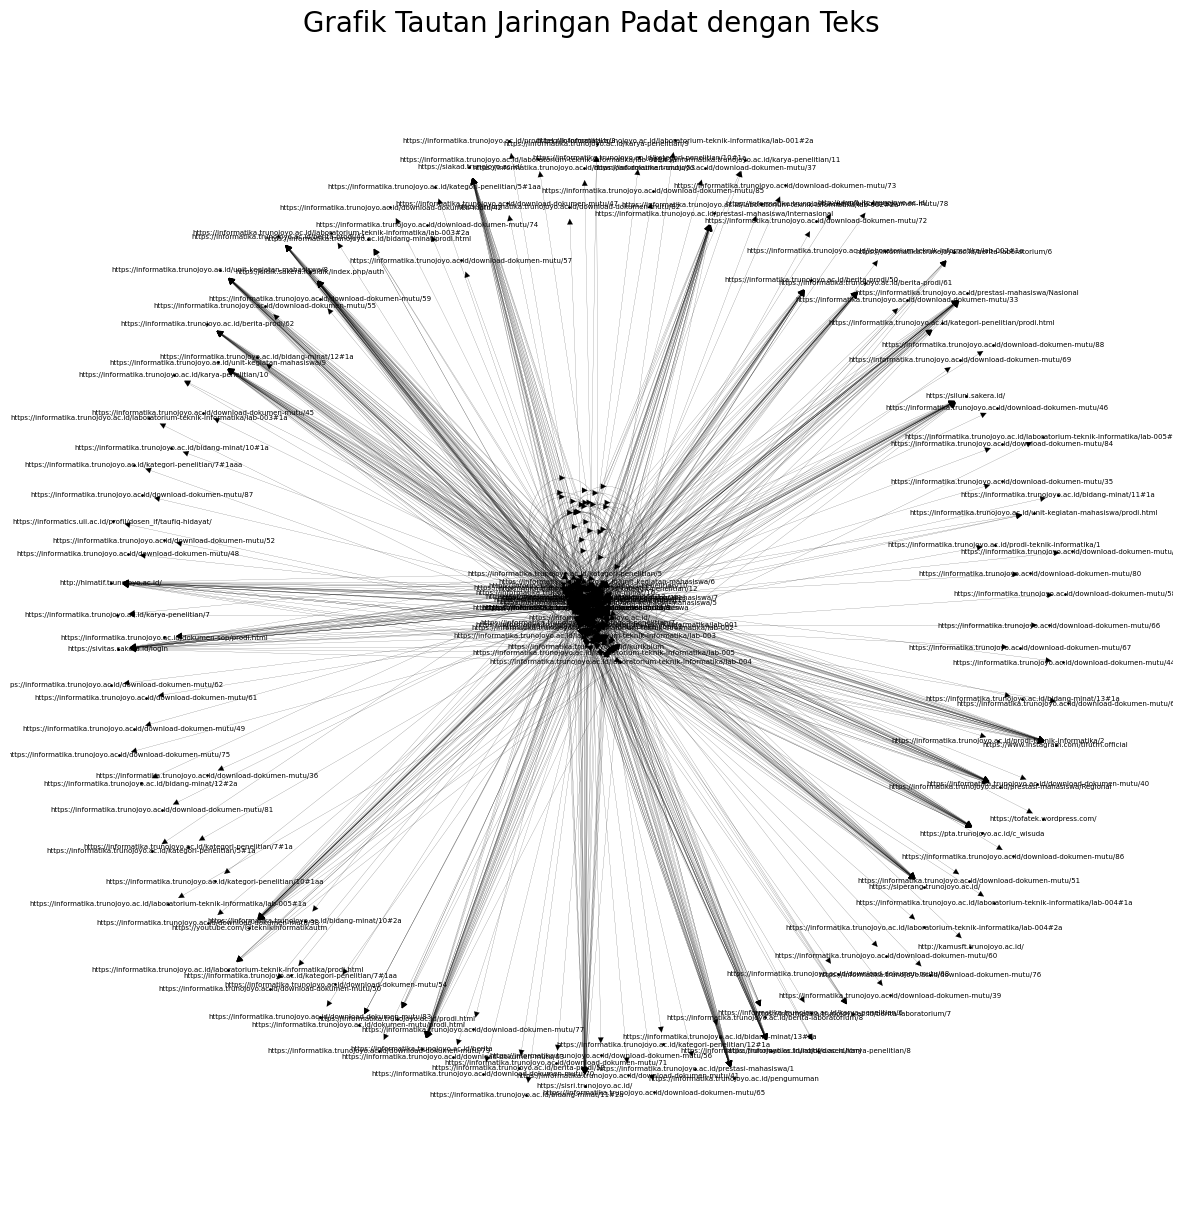

In [8]:
import urllib3
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Matikan warning SSL insecure
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

def scrape_all_links(base_url, max_pages=50):
    """
    Mengambil semua tautan dari sebuah situs web hingga batas halaman tertentu.
    
    Args:
        base_url (str): URL dasar situs web.
        max_pages (int): Batas jumlah halaman yang akan dijelajahi.
        
    Returns:
        pd.DataFrame: DataFrame yang berisi 'Page' dan 'Link Keluar'.
    """
    visited = set()
    results = []

    def scrape_page(url):
        try:
            response = requests.get(url, verify=False, timeout=10)
            soup = BeautifulSoup(response.text, 'html.parser')

            # Ambil semua link keluar
            for a in soup.find_all('a', href=True):
                href = a['href'].strip()
                if not href or href == "#":
                    continue
                full_link = urljoin(url, href)
                results.append({
                    "Page": url,
                    "Link Keluar": full_link
                })

            # Cari link internal untuk dilanjutkan
            for a in soup.find_all('a', href=True):
                href = a['href'].strip()
                if not href or href == "#":
                    continue
                full_link = urljoin(url, href)
                if full_link.startswith(base_url) and full_link not in visited:
                    visited.add(full_link)
                    if len(visited) < max_pages:
                        scrape_page(full_link)

        except Exception as e:
            print(f"⚠️ Gagal akses {url}: {e}")

    visited.add(base_url)
    scrape_page(base_url)

    df = pd.DataFrame(results).reset_index(drop=True)
    df.index += 1
    df.insert(0, "No", df.index)
    return df

def visualize_dense_text_graph(df):
    """
    Membuat dan memvisualisasikan grafik yang padat dengan label teks.
    
    Args:
        df (pd.DataFrame): DataFrame yang berisi kolom 'Page' dan 'Link Keluar'.
    """
    G = nx.DiGraph()

    # Tambahkan node dan edge dari dataframe
    for index, row in df.iterrows():
        page = row['Page']
        link = row['Link Keluar']
        G.add_edge(page, link)

    # Konfigurasi visualisasi
    plt.figure(figsize=(15, 15))
    
    # Atur layout grafik agar padat dan terpusat
    pos = nx.spring_layout(G, k=0.05, iterations=50)
    
    # Gambar node (titik) dengan ukuran sangat kecil
    nx.draw_networkx_nodes(G, pos, node_size=1, node_color='black')
    
    # Gambar edge (garis) dengan ketebalan sangat tipis
    nx.draw_networkx_edges(G, pos, edge_color='black', width=0.1)

    # Gambar label node (teks)
    nx.draw_networkx_labels(G, pos, font_size=5, font_color='black')

    # Tambahkan judul
    plt.title("Grafik Tautan Jaringan Padat dengan Teks", size=20)
    plt.axis('off')
    plt.show()

# --- LANGKAH PENGGUNAAN ---

if __name__ == "__main__":
    # Pastikan Anda sudah menginstal pustaka yang dibutuhkan
    # pip install networkx matplotlib pandas requests beautifulsoup4

    # Definisikan URL dan batas halaman
    url = "https://informatika.trunojoyo.ac.id/"
    max_pages_to_crawl = 30 # Anda bisa menambah ini untuk data lebih banyak

    # 1. Jalankan fungsi web scraping untuk membuat dataframe
    df_links = scrape_all_links(url, max_pages=max_pages_to_crawl)

    # 2. Cek apakah dataframe berhasil dibuat dan berisi data
    if not df_links.empty:
        print("DataFrame berhasil dibuat. Jumlah tautan ditemukan:", len(df_links))
        print("5 baris pertama DataFrame:")
        print(df_links.head())
        print("\nMembuat grafik visualisasi...")
        
        # 3. Visualisasikan grafik dari dataframe
        visualize_dense_text_graph(df_links)
    else:
        print("⚠️ DataFrame kosong. Tidak ada tautan yang ditemukan.")
    

## Crawling Berita

In [7]:
import requests
from bs4 import BeautifulSoup
import time
import re
import string
import sys
import pandas as pd
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import random

# --- FUNGSI-FUNGSI BANTUAN SCRAPING ---
def print_progress(kategori, current_page, total_pages):
    """Menampilkan progress bar di konsol."""
    percent = (current_page / total_pages) * 100 if total_pages > 0 else 0
    bar_length = 20
    filled_length = int(bar_length * current_page // total_pages) if total_pages > 0 else 0
    bar = '█' * filled_length + '-' * (bar_length - filled_length)
    sys.stdout.write(f'\r{kategori} - Page {current_page}/{total_pages} [{bar}] {percent:.2f}%')
    sys.stdout.flush()
    if current_page == total_pages:
        sys.stdout.write('\n\n')

def get_session():
    """Membuat sesi permintaan dengan mekanisme percobaan ulang."""
    session = requests.Session()
    retry_strategy = Retry(
        total=5,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET"],
        backoff_factor=1
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session.mount("https://", adapter)
    return session

def get_article_content_and_title(session, url):
    """Mengambil isi artikel dan judul dari URL."""
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
    }
    try:
        r = session.get(url, headers=headers, timeout=15)
        r.raise_for_status()
        soup = BeautifulSoup(r.text, "html.parser")

        title = get_article_title(soup)
        content_selectors = [
            "div.detail-konten", "div.news-detail__content", "div.itp_bodycontent",
            "div.content-text", "div.article-content", "div.text_area"
        ]

        paragraphs = []
        for selector in content_selectors:
            content_divs = soup.select(selector)
            if content_divs:
                for div in content_divs:
                    for p in div.find_all("p"):
                        text = p.get_text(strip=True)
                        if text and not text.lower().startswith("baca juga"):
                            paragraphs.append(text)
                if paragraphs:
                    break
        
        if not paragraphs:
            body_text = soup.find("article")
            if body_text:
                for p in body_text.find_all("p"):
                    text = p.get_text(strip=True)
                    if text and not text.lower().startswith("baca juga"):
                        paragraphs.append(text)

        content = " ".join(paragraphs)
        return title, content
    except requests.exceptions.RequestException as e:
        print(f"Error fetching {url}: {e}", file=sys.stderr)
        return "Judul Tidak Ditemukan", ""

def get_article_title(soup):
    """Mengambil judul artikel dari berbagai kemungkinan lokasi."""
    title_tag = soup.find("h1", class_="detail-title")
    if title_tag:
        return title_tag.get_text(strip=True)
    
    title_tag = soup.find("h2", class_="media__title")
    if title_tag:
        return title_tag.get_text(strip=True)
        
    title_tag = soup.find("title")
    if title_tag:
        return title_tag.get_text(strip=True).replace(" - detiknews", "").replace(" - detikfinance", "")

    return "Judul Tidak Ditemukan"

def extract_id(url):
    """
    Ekstrak ID berita dari URL, mengatasi format yang berbeda.
    """
    id_match_d = re.search(r"/d-(\d+)", url)
    if id_match_d:
        return id_match_d.group(1)
    id_match_end = re.search(r"-(\d+)$", url)
    if id_match_end:
        return id_match_end.group(1)
    id_match_middle = re.search(r"(\d+)\.html$", url)
    if id_match_middle:
        return id_match_middle.group(1)
        
    return None

# --- FUNGSI UTAMA SCRAPING ---
def berita(categories, pages_per_category=10):
    """Fungsi utama untuk melakukan crawling berita dan menyimpan hasilnya."""
    start_time = time.time()
    session = get_session()
    all_articles_data = []
    processed_links = set()

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
    }

    base_urls = {
        "politik": "https://news.detik.com/indeks/berita/",
        "hukum": "https://news.detik.com/indeks/berita/",
        "ekonomi": "https://finance.detik.com/indeks/",
        "detikx": "https://news.detik.com/x/indeks/",
        "hiburan": "https://hot.detik.com/indeks/",
        "internasional": "https://news.detik.com/indeks/berita/",
        "sepakbola": "https://sport.detik.com/sepakbola/indeks/",
        "olahraga": "https://sport.detik.com/indeks/",
        "lingkungan": "https://www.detik.com/tag/lingkungan",
        "otomotif": "https://oto.detik.com/indeks"
    }
    
    categories = list(set(categories))

    for cat in categories:
        current_url = base_urls.get(cat.lower(), f"https://{cat.lower()}.detik.com/indeks/")
        print(f"--- Memulai crawling untuk kategori: {cat} ---")
        
        for page_count in range(1, pages_per_category + 1):
            url = f"{current_url}?page={page_count}"
            if cat.lower() == "lingkungan":
                url = f"https://www.detik.com/tag/lingkungan?page={page_count}"
            
            print_progress(cat, page_count, pages_per_category)

            try:
                r = session.get(url, headers=headers, timeout=15)
                r.raise_for_status()
                soup = BeautifulSoup(r.text, "html.parser")
                article_links = soup.select("a.media__link")
                
                for a in article_links:
                    link = a["href"]
                    if link in processed_links:
                        continue
                    processed_links.add(link)
                    berita_id = extract_id(link)
                    title, content = get_article_content_and_title(session, link)
                    
                    if content:
                        print(f"\n--- Data {len(all_articles_data) + 1} ---")
                        print(f"ID Berita: {berita_id}")
                        print(f"Judul: {title}")
                        print(f"Abstrak (Raw): {content}")
                        print(f"Kategori: {cat}")
                        print("-------------------------------------------\n")

                        all_articles_data.append({
                            "id_berita": berita_id,
                            "judul_berita": title,
                            "isi_berita_original": content,
                            "kategori_berita": cat
                        })
                    time.sleep(random.uniform(1, 3))
            except requests.exceptions.RequestException as e:
                print(f"\n❌ Gagal mengakses {url}: {e}", file=sys.stderr)
                break
    
    df = pd.DataFrame(all_articles_data)
    df.to_csv("crawling_detik_berita.csv", index=False, encoding="utf-8-sig")

    end_time = time.time()
    elapsed = int(end_time - start_time)
    jam, sisa = divmod(elapsed, 3600)
    menit, detik = divmod(sisa, 60)

    print("\n✅ Seluruh data berhasil dikumpulkan!")
    print(f"📊 Total entri: {len(df)}")
    print(f"⏱️ Waktu eksekusi: {jam} jam {menit} menit {detik} detik")
    
    print("\nBerikut adalah 5 entri pertama yang berhasil dikumpulkan:")
    print(df.head())

    return df

if __name__ == '__main__':
    categories = ["politik", "hukum", "ekonomi", "lingkungan", "hiburan", "internasional", "otomotif", "olahraga", "sepakbola"]
    berita(categories, pages_per_category=5)

--- Memulai crawling untuk kategori: sepakbola ---
sepakbola - Page 1/5 [████----------------] 20.00%
--- Data 1 ---
ID Berita: 8117656
Judul: Federasi Futsal Indonesia Yakin Erick Bawa Terobosan untuk Olahraga
Abstrak (Raw): Federasi Futsal Indonesia (FFI)mendukung penunjukanErick ThohirsebagaiMenpora. Ketum PSSI tersebut dinilai punya kapabilitas untuk mengembangkan dunia olahraga. Erick Thohir dilantik sebagai Menpora oleh Presiden RI Prabowo Subianto di Istana Negara, Rabu (17/9/2025). Ia menggantikan Dito Ariotedjo yang lengser awal pekan lalu. Di sisi lain, Erick Thohir dicopot dari kursi Menteri BUMN. Untuk itu Erick Thohir akan rangkap jabatan sebagai Ketum PSSI dan juga Menpora. SCROLL TO CONTINUE WITH CONTENT Menanggapi pelantikan tersebut, Ketua Umum FFI Michael Victor Sianipar menyampaikan optimisme bahwa dunia olahraga Indonesia akan berkembang semakin pesat lagi di bawah kepemimpinan Erick Thohir. Sebagai informasi, FFI merupakan salah satu asosiasi di bawah naungan PSSI 

Error fetching https://sport.detik.com/sepakbola/uefa/d-8116937/juventus-tidak-kalah-tapi-pertahanan-mengkhawatirkan: HTTPSConnectionPool(host='sport.detik.com', port=443): Read timed out.



--- Data 12 ---
ID Berita: 8116105
Judul: Kans Lewandowski Jadi Raja Penalti Liga Champions
Abstrak (Raw): Jakarta- Robert Lewandowski punya kans jadi raja penalti Liga Champions. Striker Barcelona itu bisa lewati capaiannya Cristiano Ronaldo. Lewandowski dan Ronaldo sama-sama punya 19 gol penalti di Liga Champions. Terbanyak dibanding pemain lainnya! (REUTERS/Nacho Doce) Lewandowski dan Ronaldo sama-sama punya 19 gol penalti di Liga Champions. Terbanyak dibanding pemain lainnya! (REUTERS/Nacho Doce) Lewandowski dan Ronaldo sama-sama punya 19 gol penalti di Liga Champions. Terbanyak dibanding pemain lainnya! (REUTERS/Nacho Doce) Pesaing terdekatnya adalah Messi dengan 18 gol penalti (AP/Joan Monfort) Pesaing terdekatnya adalah Messi dengan 18 gol penalti (AP/Joan Monfort) Pesaing terdekatnya adalah Messi dengan 18 gol penalti (AP/Joan Monfort) Harry Kane jadi pemain yang masih aktif dan bisa dekati Lewandowski. Kane punya 11 gol penalti di Liga Champions (Getty Images/Shaun Botterill)